### Imports & data Directory

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.tree
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from natsort import natsorted, ns
from skimage import io, color
import math
import natsort
import skimage
import matplotlib.image as img
from matplotlib import markers
import scipy.misc
from scipy import ndimage
import seaborn as sns
import warnings
from IPython.display import display, HTML
import graphviz
from dtreeviz.trees import dtreeviz

%matplotlib inline

In [2]:
#Directory
data = 'HPTLCRaw\\'
dataTreeLeafEncoding = 'treeLeafEncodingData\\'


### Grey Scale Import

##### Import Images as Grey Scale

In [3]:
list_files = os.listdir(data)
list_files = natsorted(list_files)
image_list = []
for filename in list_files:
    image_list.append(color.rgb2gray(io.imread(data+filename)[:,:,:3]))

##### Crop all Images

In [4]:
cropped_img_list = []
for image in image_list:
    cropped_img_list.append(image[70:1100,96:-84])

##### Plot Every Cropped File as a Greyscale Image

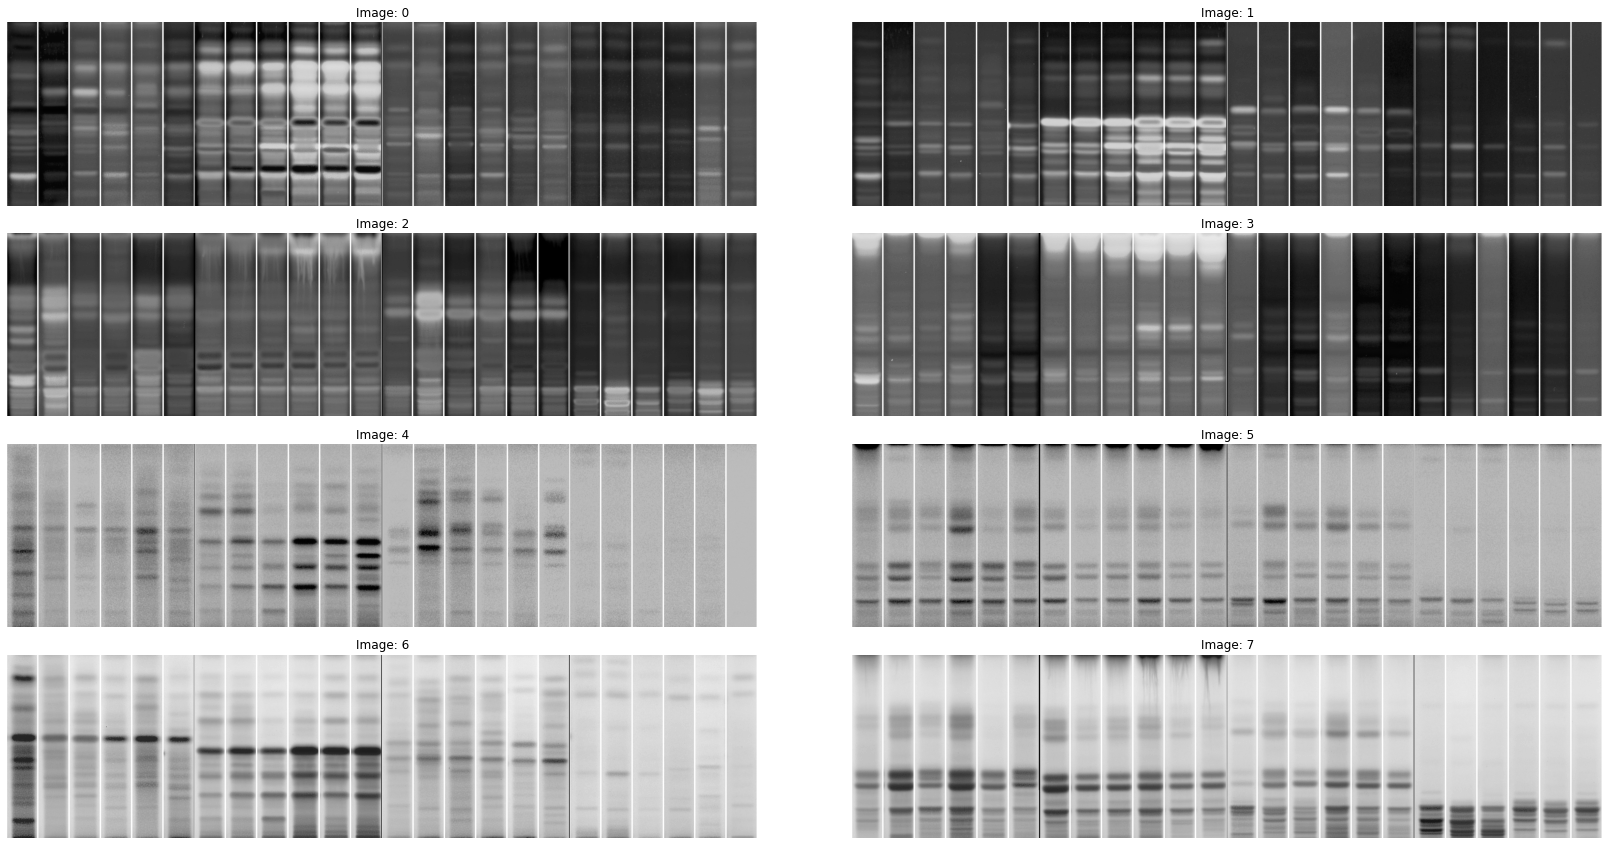

In [5]:
fig = plt.figure(figsize=(30, 15))
for i, img in enumerate(cropped_img_list):
    sub = fig.add_subplot(4, 2, i + 1)
    sub.axis('off')
    sub.imshow(img,cmap='gray')
    sub.set_title('Image: '+str(i))
plt.tight_layout
fig.subplots_adjust(wspace=.02, hspace=.15)

##### Verifying Shape of each Cropped Image


In [6]:
for i in range(len(cropped_img_list)):
    print(np.shape(cropped_img_list[i]))

(1030, 4220)
(1030, 4220)
(1030, 4220)
(1030, 4220)
(1030, 4220)
(1030, 4220)
(1030, 4220)
(1030, 4220)


### Algorithm to determine crop locations

In [7]:
def det_crop_locations(ar):
    maxVal = ar.max()
    res = []
    res.append([0,0])
    n = len(ar)

    i = 10
    while i < len(ar-5):
        # While we are within bounds and
        # we have not found a peak or
        # haven't yet travelled at least 100 pixels or
        # are not within 5% of the max value
        # increment i
        while (i < n-5) and (not (ar[i] >= ar[i-1] and ar[i] >= ar[i+1]) or not (i - res[-1][0] > 100) or not(ar[i] > (.85*maxVal))):
            i += 1

        #if we reach the end of the image, break the loop
        if i >= n-5:
            break

        # Add Back wall of single strip to q
        res[-1][1] = i - 15
        
        #Add front wall to q
        res.append([i + 15,0])
        
    #remove last appended crop as it is at the end of the image and therefore not useful
    res.pop()
    return res

#### Use Function to Determine Crop Locations of Each Image

In [8]:
crops_list = []
for cropped_img in cropped_img_list:
    temp = pd.DataFrame(cropped_img)
    temp_hi_cnt = temp[temp>.8].count()
    temp_low_cnt = temp[temp==0].count()
    temp_cnt = temp_hi_cnt + temp_low_cnt
    crops_list.append(det_crop_locations(temp_cnt.copy()))

In [9]:
# Verify Number of Crops for Each Image
for crops in crops_list:
    print(len(crops))

24
24
24
24
24
24
24
24


##### Generate Plot of Crop Locations for all Images -> Common Sense Check Reasonability of Algorithm Results

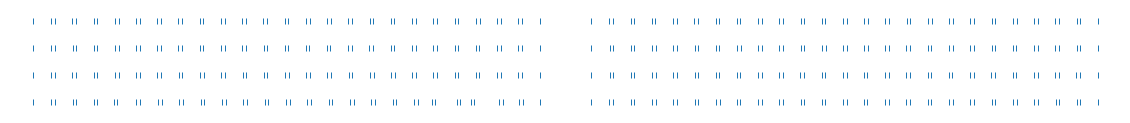

In [10]:
fig = plt.figure(figsize=(20, 2))
for i, crops in enumerate(crops_list):
    temp = pd.DataFrame(crops).to_numpy().flatten()
    sub = fig.add_subplot(4,2,i+1)
    sub.axis('off')
    sub.plot(temp,np.zeros_like(temp),'|')
plt.tight_layout
fig.subplots_adjust(wspace=.001, hspace=0)

##### Cropping Images and adding Individual Slices to new Array

In [11]:
multiview_strip_array = []

#For every View
for i, cropped_image in enumerate(cropped_img_list):
    min_width = float('inf')
    strip_array = []

    #First find the minimum width of all the crops
    for crop in crops_list[i]:
        front, back = crop
        min_width = min(min_width,back-front)

    #Get half of that min width
    min_width_half = int((min_width-2)/2)

    #For each of the crops, crop them from their own midpoint +- the mind_width_half value
    for crop in crops_list[i]:
        front, back = crop
        strip_mid = int(back/2 + front/2)
        min_front = strip_mid - min_width_half
        min_back = min_width_half + strip_mid
        strip_array.append(cropped_image[:,min_front:min_back])

    multiview_strip_array.append(strip_array)

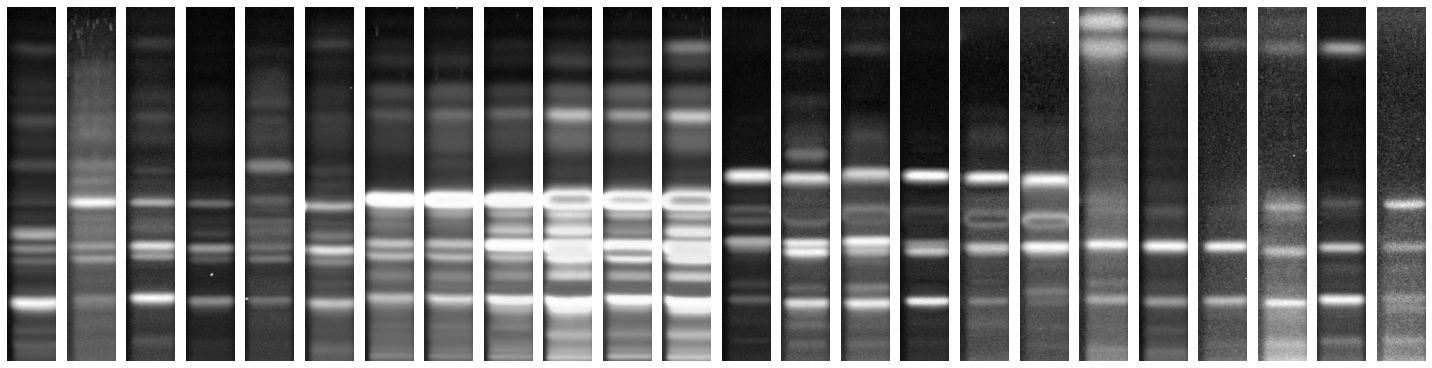

In [12]:
# Individual Print
# strip_array = strip_array_list[1]
strip_array = multiview_strip_array[1]
fig = plt.figure(figsize=(20, 10))
for i, strip in enumerate(strip_array):
    sub = fig.add_subplot(1, 24, i + 1)
    sub.axis('off')
    sub.imshow(strip,cmap='gray')
plt.tight_layout()

### Transforming each Strip in array to a 1D Vector by getting average value of each row

In [13]:
multiview_strip_row_avg_list = []

for strip_array in multiview_strip_array:
    strip_row_avg = []

    for i, strip in enumerate(strip_array):
        strip_row_avg.append([])
        for row in strip:
            strip_row_avg[i].append(row.mean())

    multiview_strip_row_avg_list.append(strip_row_avg)

In [14]:
np.shape(multiview_strip_row_avg_list[0][0])

(1030,)

In [15]:
np.shape(np.transpose([multiview_strip_row_avg_list[0][i] for k in range(min_width)]))

(1030, 140)

#### Plotting arrays of average values to verify mean of each row

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

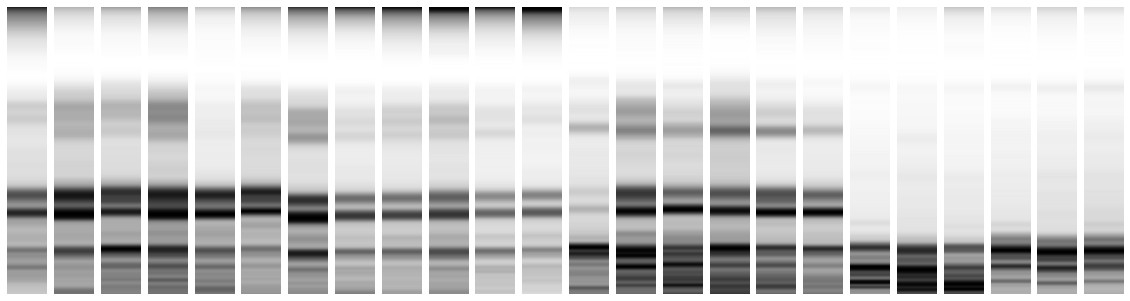

In [16]:
# Individual
fig = plt.figure(figsize=(20, 10)) 
for i in range(24):
    sub = fig.add_subplot(1, 24, i + 1)
    sub.axis('off')
    img = [multiview_strip_row_avg_list[-1][i] for k in range(min_width)]
    img = np.transpose(img)
    sub.imshow(img, cmap='gray')
plt.tight_layout

### Setting up Target Values & Dictionary Mapping

In [17]:
# 1 (GG): Rows 1 - 6 
# 2 (GI): Rows 7 - 12
# 3 (GU): Rows 13 - 18
# 4 (GE): Rows 19 - 21
# 5 (GL): Rows 22 - 24
map = {1:'GG',2:'GI',3:'GU',4:'GE',5:'GL'}
print(map[4])

GE


In [18]:
np.shape(multiview_strip_row_avg_list)

(8, 24, 1030)

In [19]:
np.shape(multiview_strip_row_avg_list[0])

(24, 1030)

In [20]:
#Done for the purposes of appending all views into 1 long feature vector later
no_targets_multiview_strip_row_avg_list = np.array(multiview_strip_row_avg_list).copy()

##### Append Targets to feature array

In [21]:
for strip_row_avg in multiview_strip_row_avg_list:
    for i in range(6):
        # strip_row_avg[i].append(1)
        strip_row_avg[i] = np.append(strip_row_avg[i],1)
    for i in range(6,12):
        # strip_row_avg[i].append(2)
        strip_row_avg[i] = np.append(strip_row_avg[i],2)
    for i in range(12,18):
        # strip_row_avg[i].append(3)
        strip_row_avg[i] = np.append(strip_row_avg[i],3)
    for i in range(18,21):
        # strip_row_avg[i].append(4)
        strip_row_avg[i] = np.append(strip_row_avg[i],4)
    for i in range(21,24):
        # strip_row_avg[i].append(5)
        strip_row_avg[i] = np.append(strip_row_avg[i],5)

In [22]:
#Verifying Shape of Multiview Multi-Dimensional Array
print(np.shape(multiview_strip_row_avg_list))

(8, 24, 1031)


In [23]:
# Verifying values are w/n the 0 - 1 range
print(np.shape(multiview_strip_row_avg_list[0][0]))
print(max(multiview_strip_row_avg_list[0][0]))
print(min(multiview_strip_row_avg_list[0][0]))

(1031,)
1.0
0.046075564761115705


### Import data about critical features per view

In [24]:
multi_view_critical_features_dirty = pd.read_csv("treeEncodedClassificationUsedFeaturesForEachView.csv",index_col=0)

In [25]:
multi_view_critical_features = []
multi_view_critical_features_dirty = multi_view_critical_features_dirty.values.tolist()
for row in multi_view_critical_features_dirty:
    temp = [int(item) for item in row if not(math.isnan(item))==True]
    temp.append(len(multiview_strip_row_avg_list[0][0])-1)
    multi_view_critical_features.append(temp)

In [26]:
multi_view_critical_features

[[58, 134, 160, 187, 252, 370, 476, 570, 670, 782, 904, 1030],
 [58, 134, 252, 370, 476, 570, 670, 782, 904, 1030],
 [58, 134, 187, 252, 370, 476, 670, 782, 904, 1030],
 [58, 134, 160, 370, 476, 570, 670, 782, 904, 1030],
 [58, 134, 160, 187, 252, 370, 476, 570, 670, 782, 1030],
 [58, 160, 187, 252, 370, 476, 570, 670, 782, 904, 1030],
 [58, 134, 160, 187, 252, 370, 476, 570, 670, 782, 904, 1030],
 [58, 134, 160, 187, 252, 370, 476, 570, 670, 782, 904, 1030]]

### Decision Tree on Single View

In [27]:
strip_row_avg = pd.DataFrame(multiview_strip_row_avg_list[0])
single_view_critical_features = multi_view_critical_features[0]

strip_row_avg_feats = strip_row_avg[single_view_critical_features[:-1]]

strip_row_avg_targets = strip_row_avg[single_view_critical_features[-1:]]


# display(strip_row_avg_feats)
# display(strip_row_avg_targets)
# display(strip_row_avg[single_view_critical_features])

In [28]:
#Get Original Feature Array
strip_row_avg = multiview_strip_row_avg_list[0]

#Convert to Dataframe
strip_row_avg = pd.DataFrame(strip_row_avg)

#Get Features
single_view_critical_features = multi_view_critical_features[0]
df_feat = strip_row_avg[single_view_critical_features[:-1]]

#Get Targets & Format to 1D vector
df_target = strip_row_avg[single_view_critical_features[-1:]]
df_target = df_target.values.ravel()

#Create Model
model = DecisionTreeClassifier()

#Set Model Parameters
model.set_params(random_state=101)

#Train Model
model.fit(df_feat,df_target)

#Print Score
print("\nView 1: ")
print("Accuracy: "+str(model.score(df_feat,df_target)))

#Print Depth
print("Depth: "+str(model.get_depth()))


View 1: 
Accuracy: 1.0
Depth: 6


In [29]:
#Get Features
single_view_critical_features = multi_view_critical_features[0]
df_feat = strip_row_avg[single_view_critical_features[:-1]]

#Get Targets & Format to 1D vector
df_target = strip_row_avg[single_view_critical_features[-1:]]
df_target = df_target.values.ravel()

#Create Model
model = DecisionTreeClassifier()

#Set Model Parameters
model.set_params(random_state=101)

#Train Model
model.fit(df_feat,df_target)

#Print Score
print("\nStrip "+str(i)+": "+str(model.score(df_feat,df_target)))

#Print Depth
print("\nStrip "+str(i)+": "+str(model.get_depth()))


Strip 23: 1.0

Strip 23: 6


### Decision Tree on All Views

,Accuracy,Depth
0,1.0,6
1,1.0,5
2,1.0,5
3,1.0,8
4,1.0,6
5,1.0,4
6,1.0,5
7,1.0,6


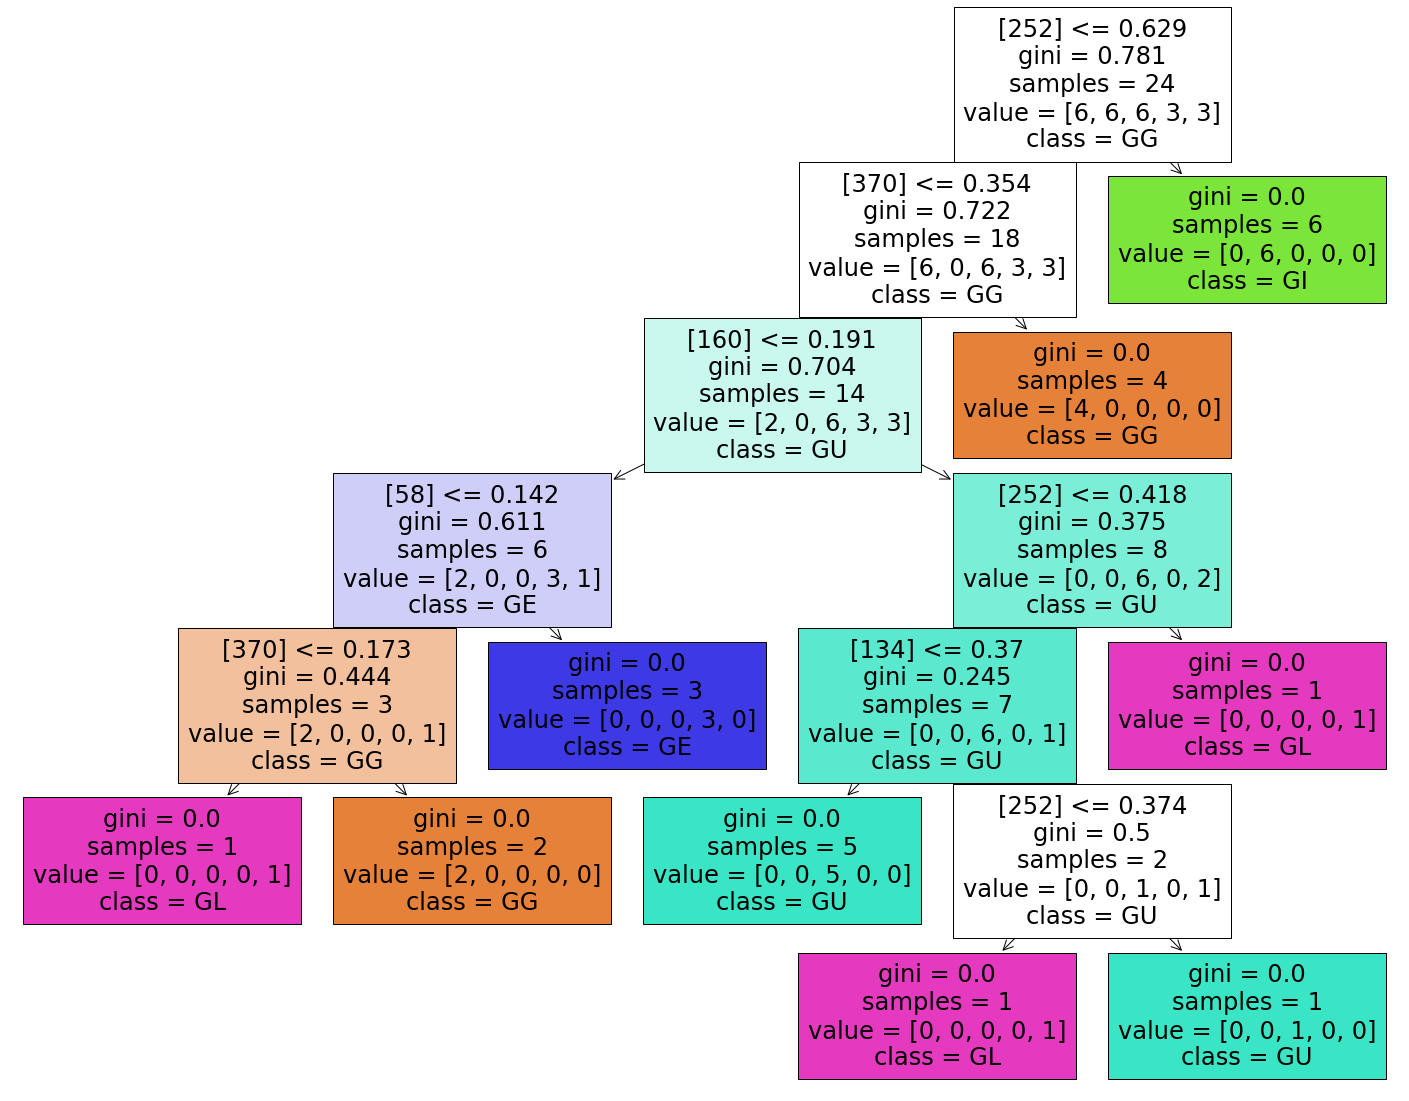

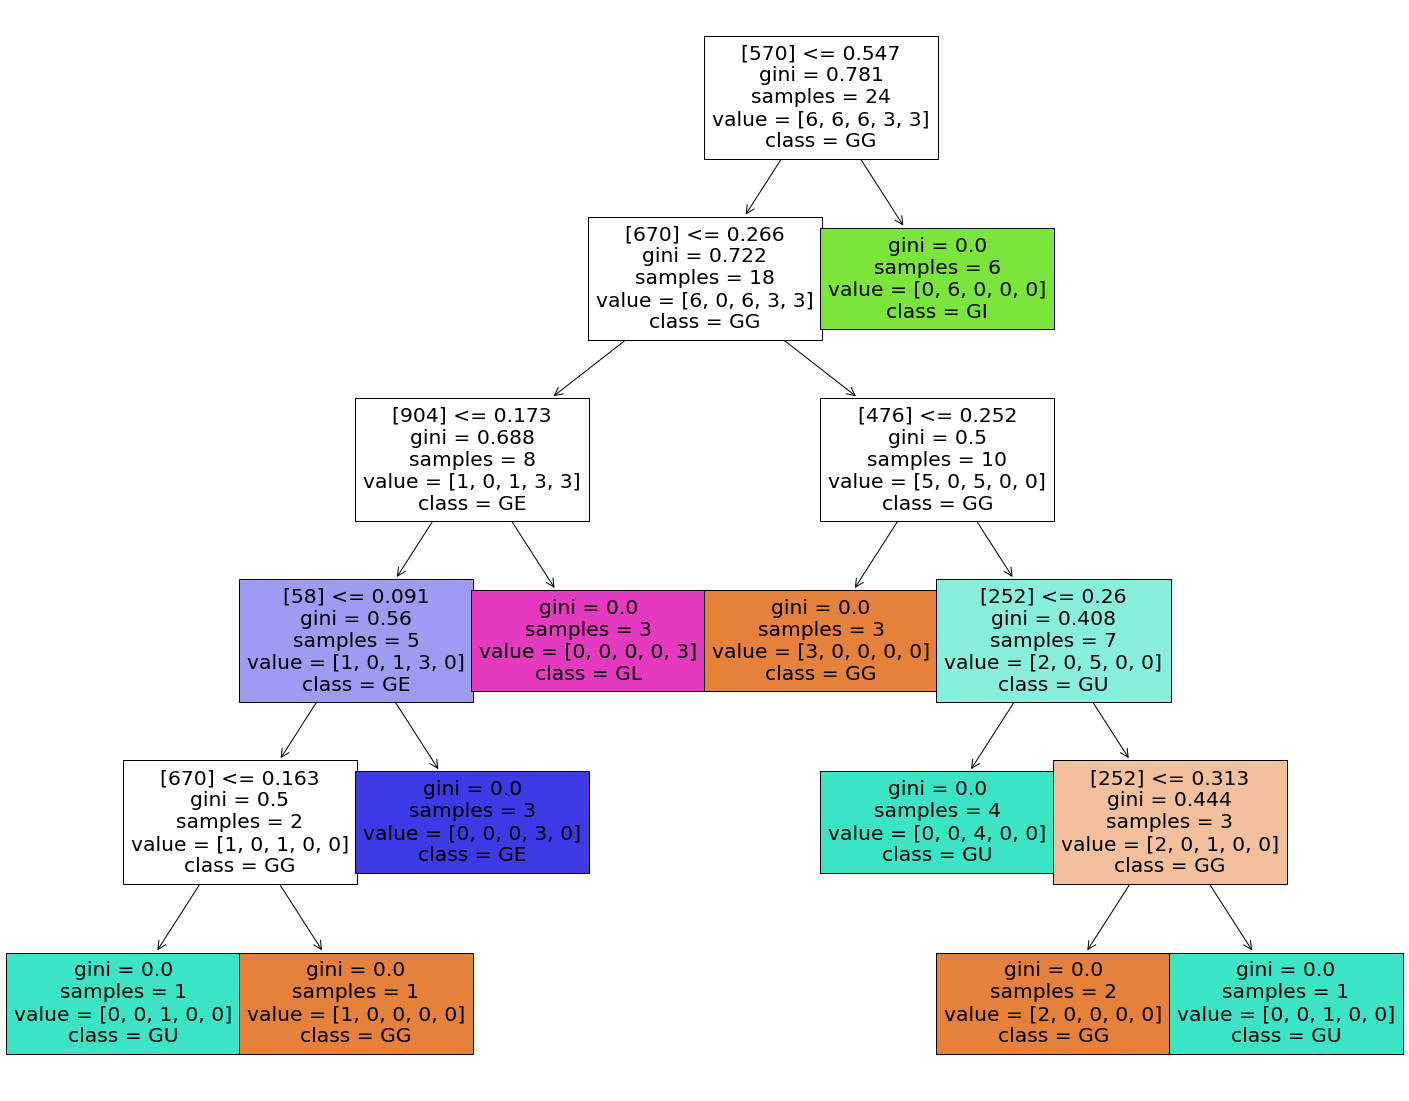

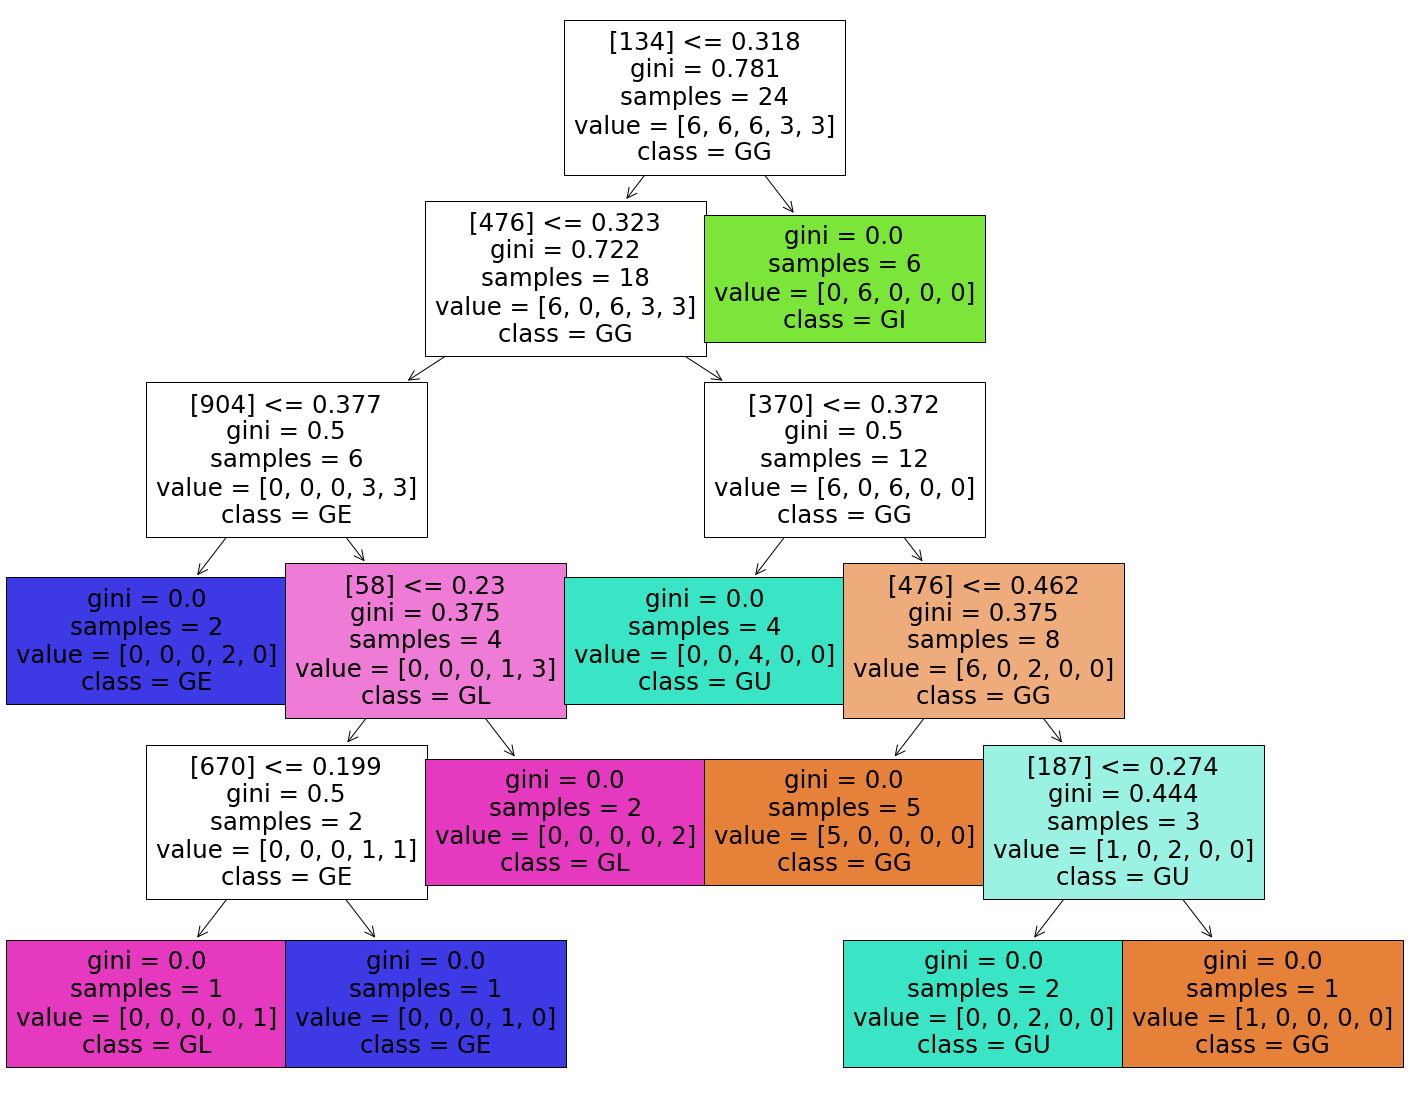

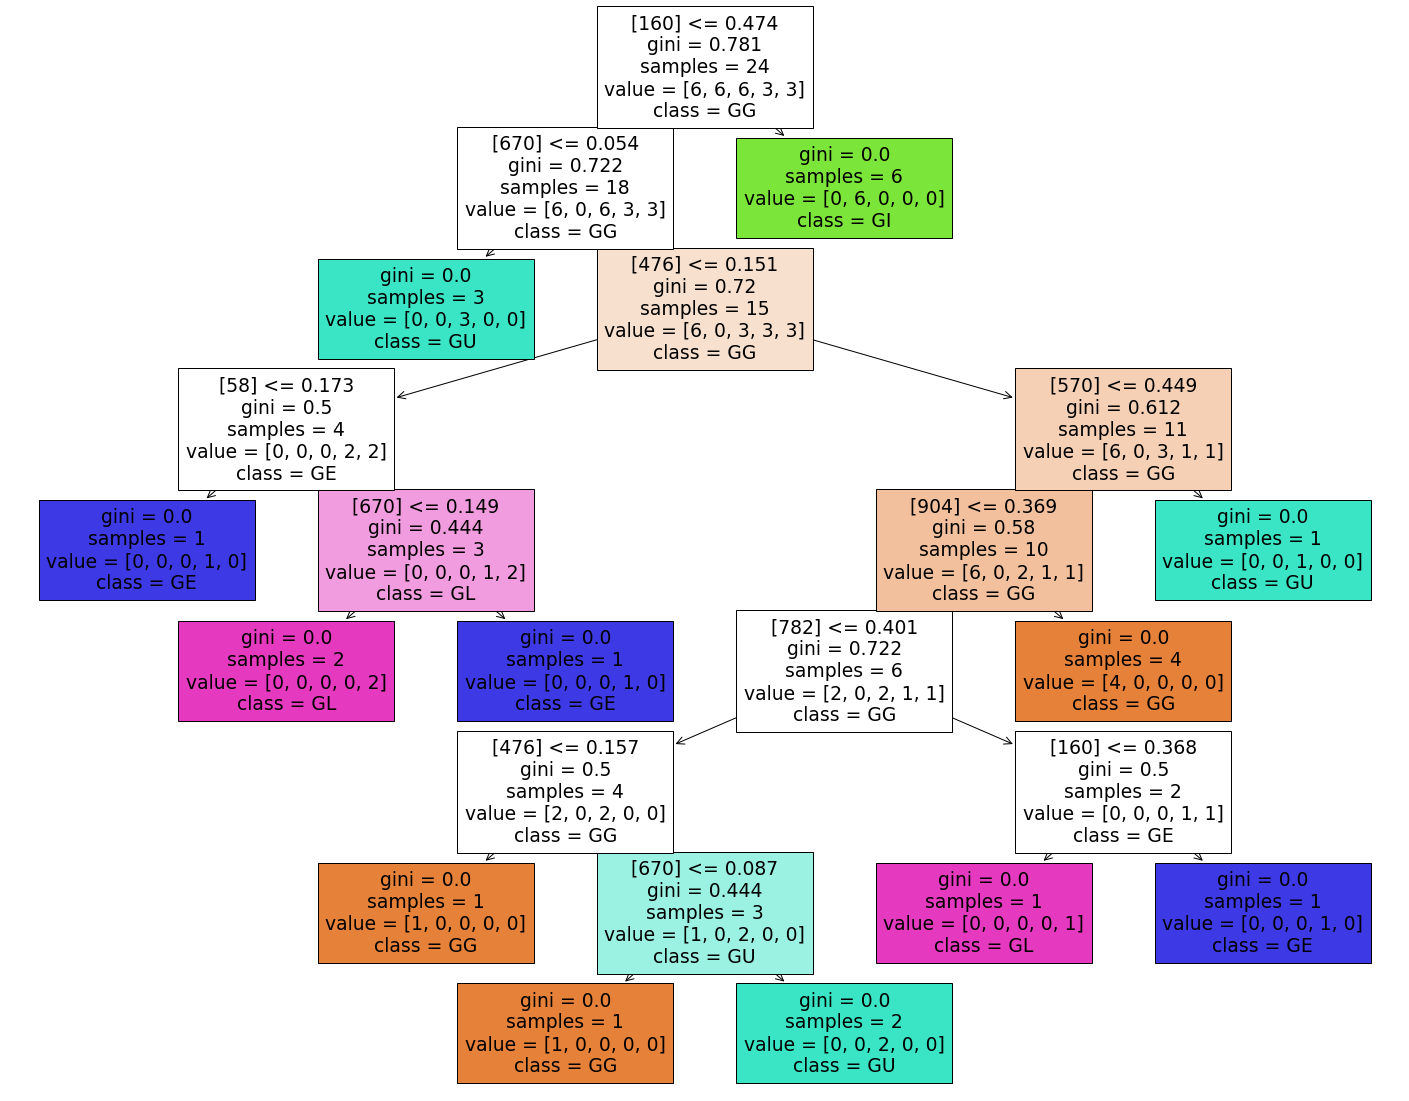

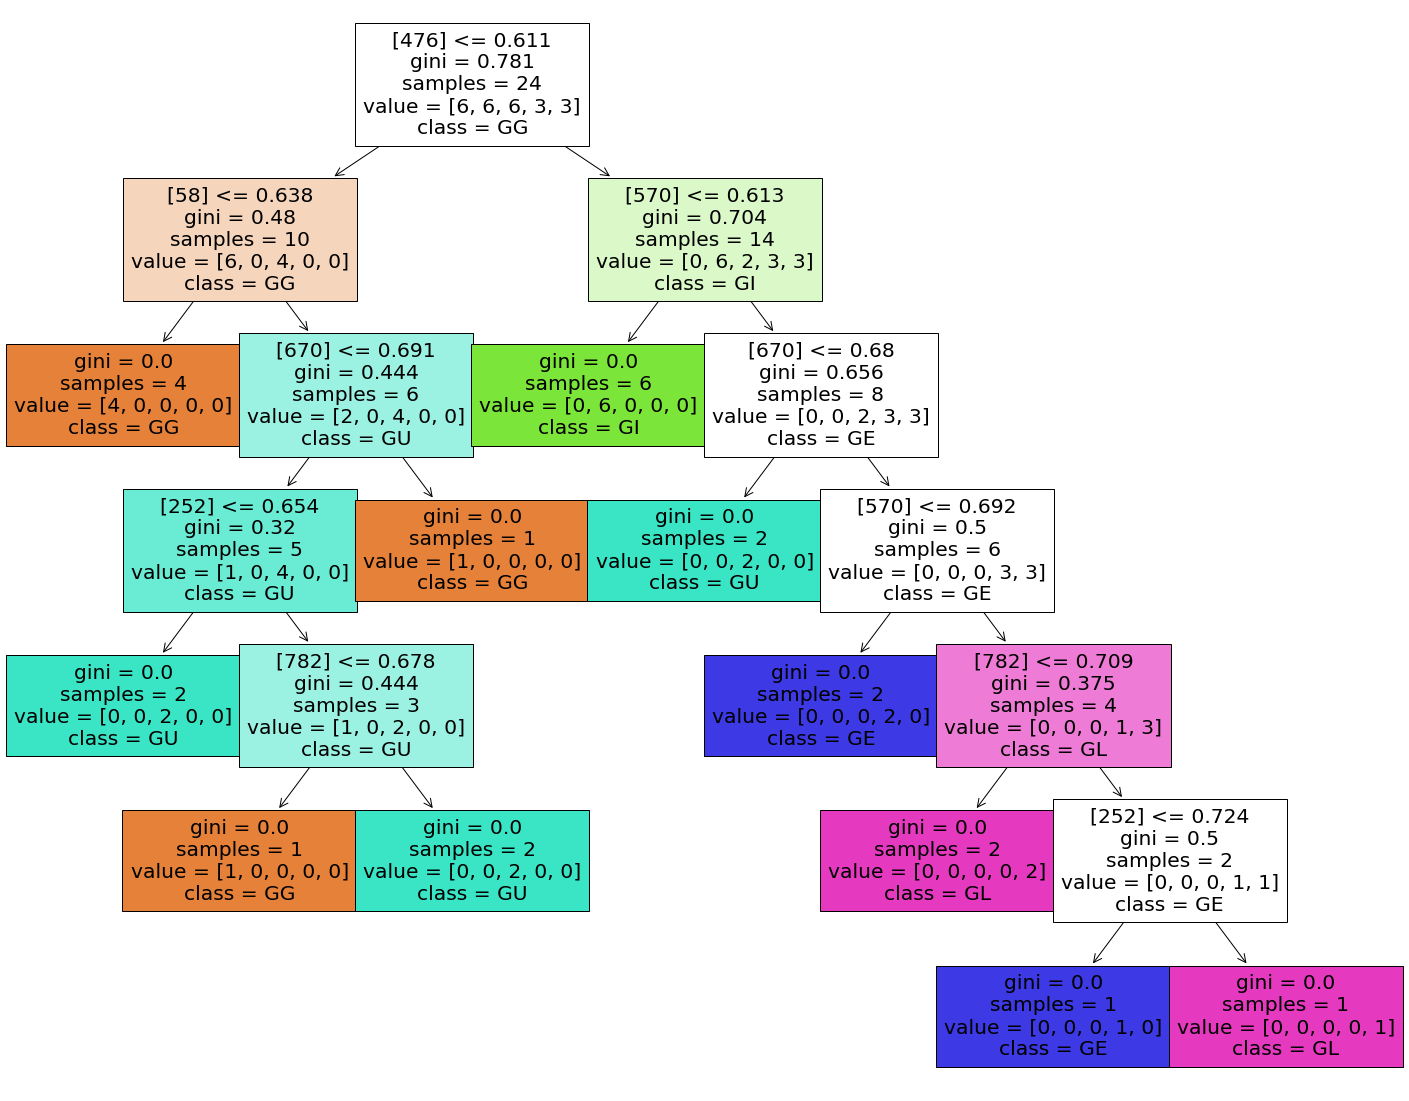

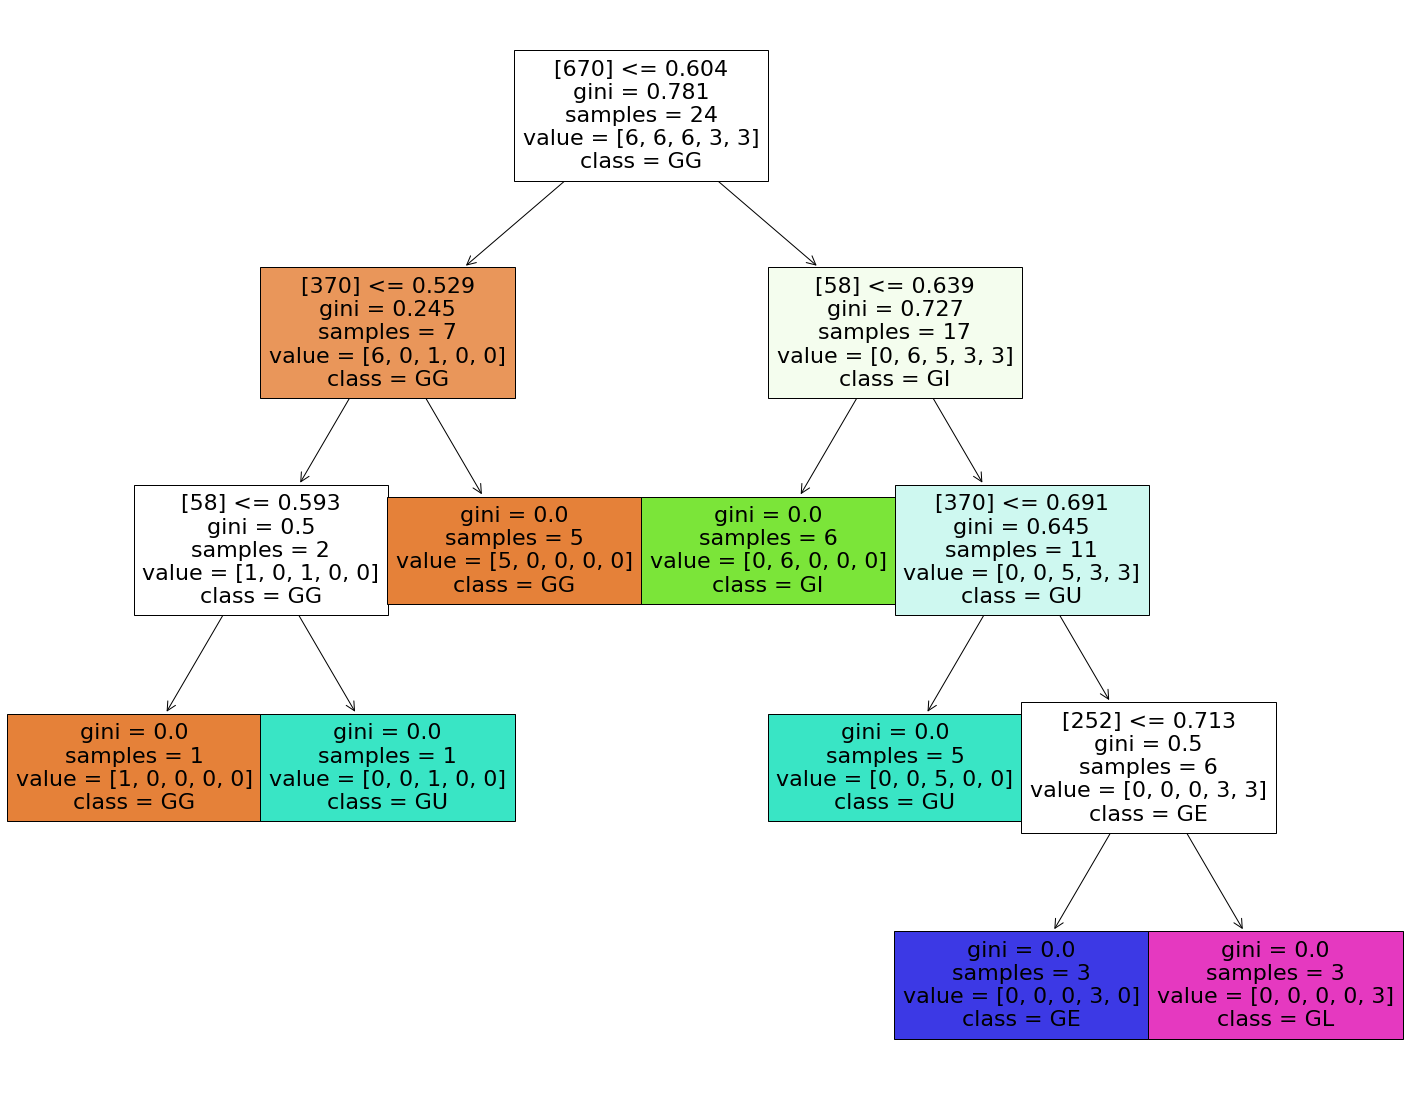

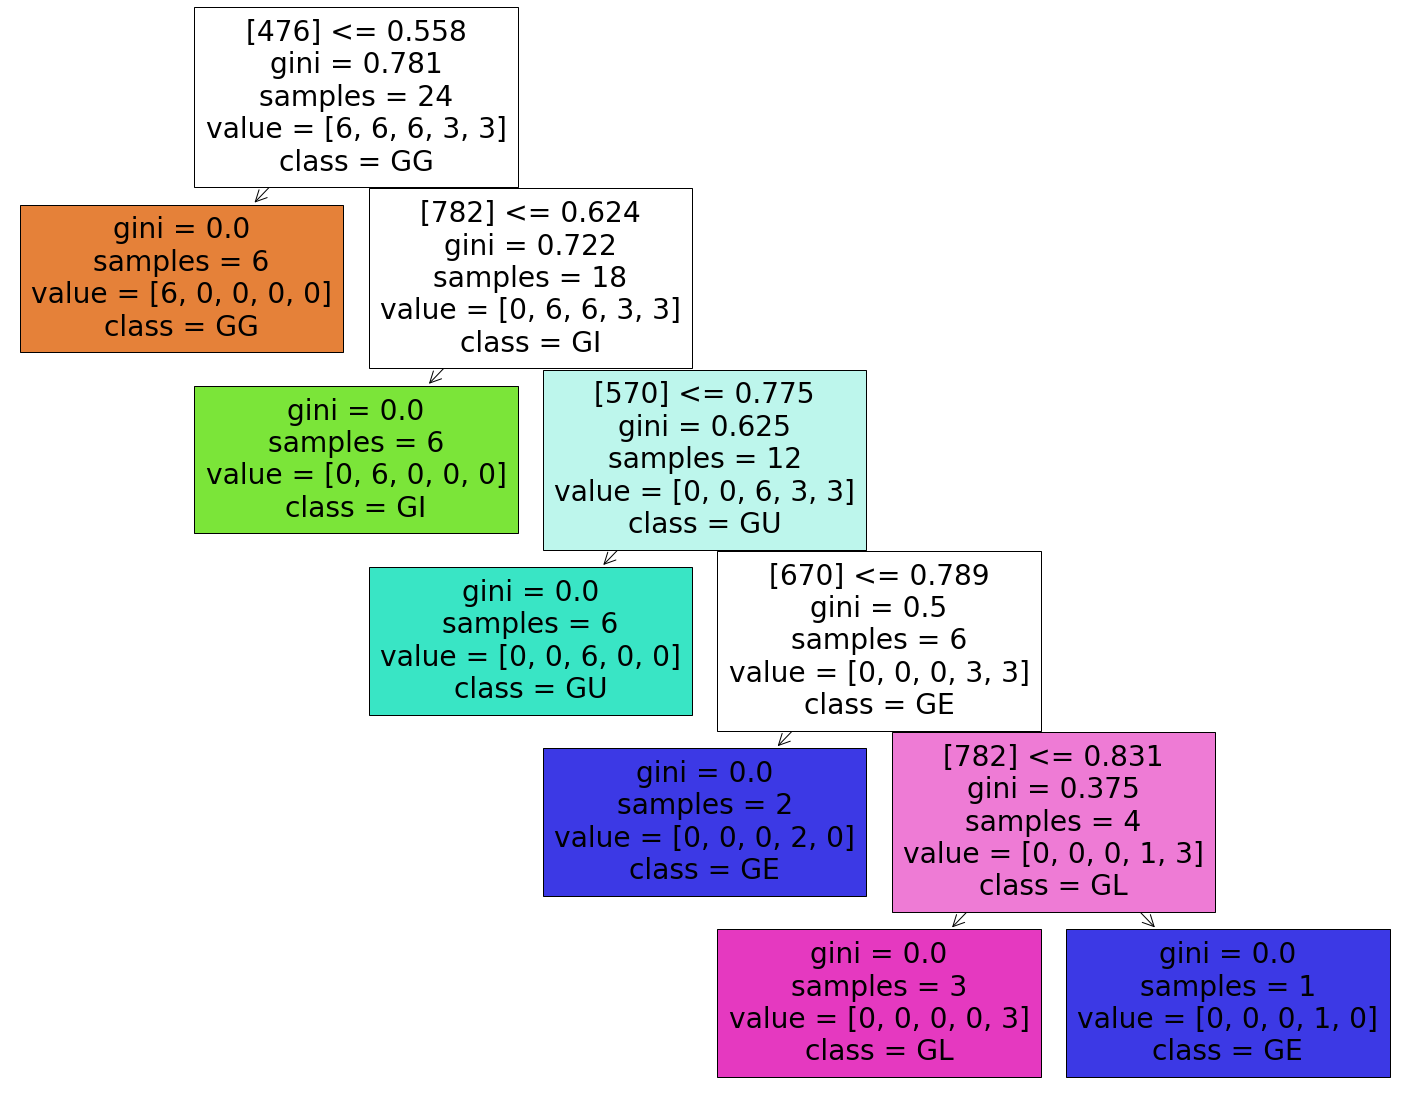

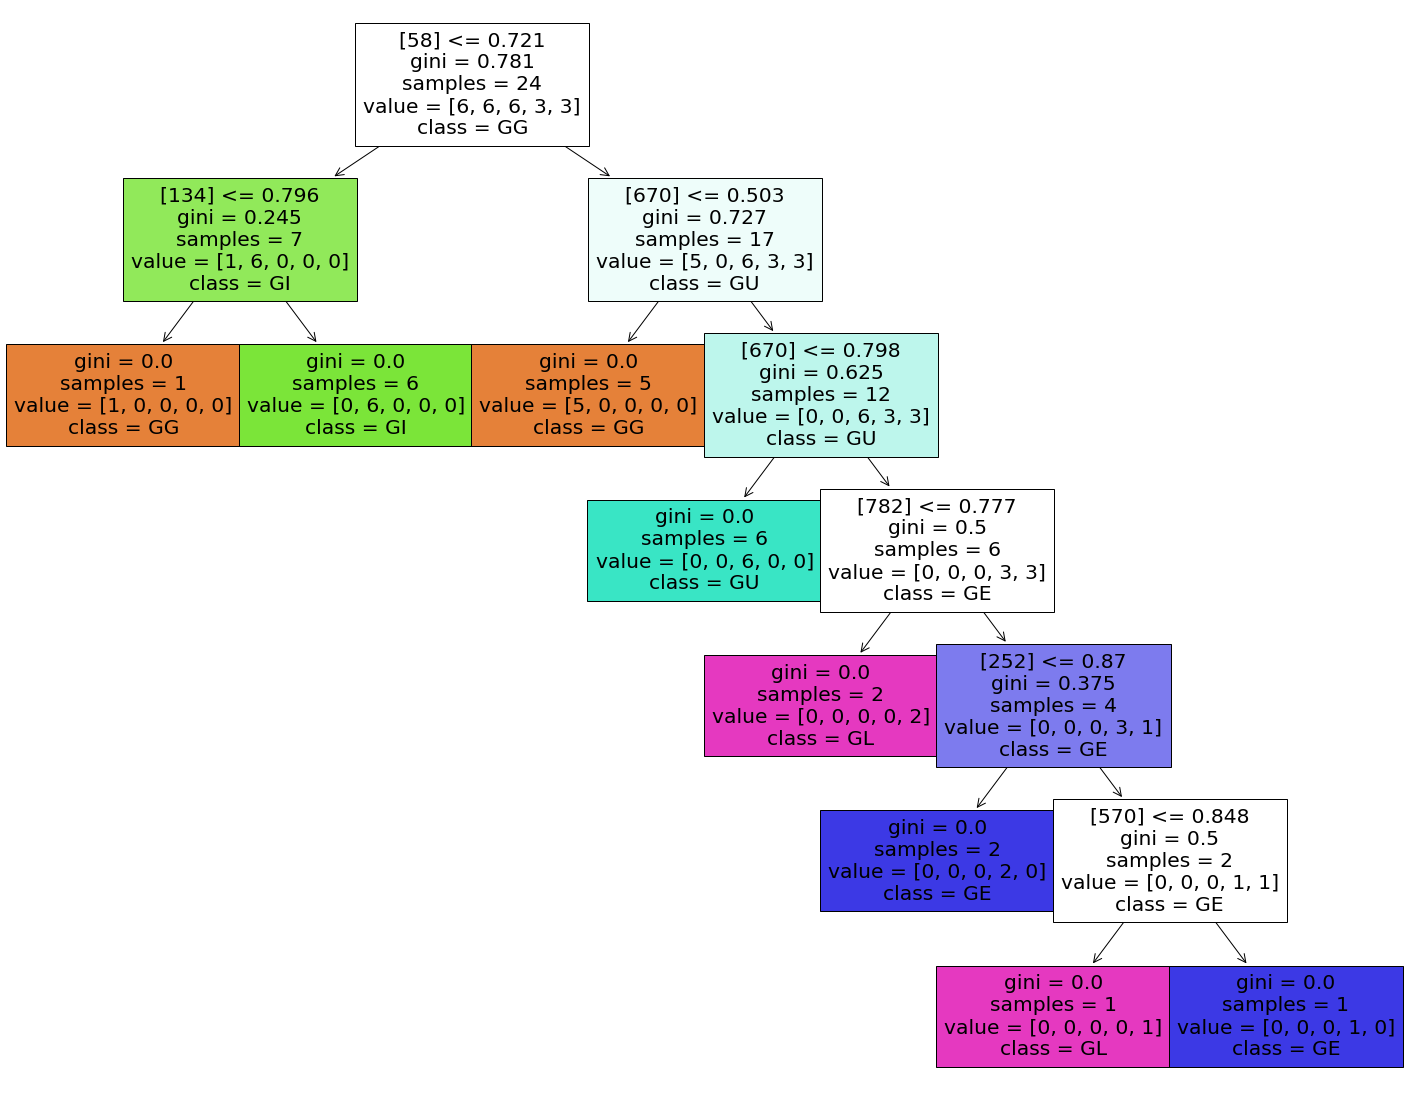

In [30]:
results = []

for i, strip_row_avg in enumerate(multiview_strip_row_avg_list):

    #Convert to Dataframe
    strip_row_avg = pd.DataFrame(strip_row_avg)

    #Get Features
    single_view_critical_features = multi_view_critical_features[i]
    df_feat = strip_row_avg[single_view_critical_features[:-1]]

    #Get Targets & Format to 1D vector
    df_target = strip_row_avg[single_view_critical_features[-1:]]
    df_target = df_target.values.ravel()

    #Create Model
    model = DecisionTreeClassifier()

    #Set Model Parameters
    model.set_params(random_state=101)

    #Train Model
    model.fit(df_feat,df_target)

    #Print Score
    # print("\nView "+str(i+1)+": ")
    score = model.score(df_feat,df_target)
    # print("Accuracy: "+str(score))

    #Print Depth
    depth = model.get_depth()
    # print("Depth: "+str(depth))

    results.append([score,depth])

    feat_names = pd.DataFrame(df_feat.columns).values.tolist()
    class_names = ['GG','GI','GU','GE','GL']

    #Plotting Tree
    fig = plt.figure(figsize=(25,20))
    _ = tree.plot_tree(model,
                        feature_names = feat_names,
                        class_names = class_names,
                        filled=True)

    #Save to PNG Files
    # dot_data = tree.export_graphviz(model, out_file=None,
    #                             feature_names = feat_names,
    #                             class_names = class_names,
    #                             filled=True, rounded=True,  
    #                             special_characters=True)  
    # graph = graphviz.Source(dot_data, format="png")
    # imgName = "DecisionTrees/View"+str(i+1)+"DecisionTree"
    # graph.render(imgName)
    
    #Complex Renders
    # viz = dtreeviz(model, df_feat, df_target,
    #             target_name="class",
    #             feature_names=feat_names,
    #             class_names=class_names)
    # viz.view()
    # break

results = pd.DataFrame(results)
results = results.rename(columns={0:"Accuracy",1:"Depth",})
display(results)